In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import load_npz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

import json
import os
import pickle

PROJ_PATH = r'F:\tmp\data science\UnnParserBot'
# CLASSES   = ['економіка', 'кримінал', 'культура', 'міжнародні новини', 'позитив', 'політика', 'спорт', 'суспільство', 'технології']
CLASSES   = ['економіка', 'кримінал', 'міжнародні новини', 'політика', 'спорт', 'суспільство']

c:\python3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
c:\python3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## LightGBM

In [4]:
# Loading the dataset, collecting the data
all_ds = load_npz(os.path.join(PROJ_PATH, 'src', 'class_data.npz')).tocsr()

# Loading the target
with open(os.path.join(PROJ_PATH, 'src', 'class_headings.hd'), 'rb') as f:
    headings = pickle.load(f)

# Loading vectorizers to obtain feature names
with open(os.path.join(PROJ_PATH, 'src', 'class_tfidf_w.vct'), 'rb') as f:
    tfidf_w = pickle.load(f)
    
with open(os.path.join(PROJ_PATH, 'src', 'class_tfidf_ch.vct'), 'rb') as f:
    tfidf_ch = pickle.load(f)

# Collecting feature names
tfidf_w_labels  = [k for k,v in sorted(list(tfidf_w.vocabulary_.items()), key=lambda x: x[1])]
tfidf_ch_labels = [k for k,v in sorted(list(tfidf_ch.vocabulary_.items()), key=lambda x: x[1])]
orig_features   = tfidf_w_labels + tfidf_ch_labels

train_ds, test_ds, y_train, y_test = train_test_split(all_ds,
                                                      headings,
                                                      test_size=0.2,
                                                      stratify=headings,
                                                      random_state=42)

le = LabelEncoder()
le.fit(CLASSES)

LabelEncoder()

In [5]:
# As lightgbm doesn't support f1-score metric out of the box, creating our own evaluation function
# based on sklearn f1-score
def my_fscore(y_hat, data):
    y_true = data.get_label()
    
    # y_hat is the preds grouped by class_id first, then group by row_id.
    # len(y_true)*parameters['num_class'] records in total
    # here we gathering predicted class for each target record
    y_pred = [np.argmax(y_hat[i::len(y_true)]) for i in range(len(y_true))]
    
    # Using weighted-F1 scoring:
    # https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1
    return 'f1 score', f1_score(y_true, y_pred, average='macro'), True

In [6]:
# Optimizing parameters on cross validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

parameters = {
    #default
    "objective"    : "multiclass",
    "num_class"    : 6,  # should be 9 when 'культура', 'технології', 'позитив' are back
    "learning_rate": 0.03,
    "num_threads"  : os.cpu_count() - 2,
    "seed"         : 42,
    
    #regularization
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq"    : 1,
    "min_data_in_leaf": 50,
    "num_leaves"      : 5
}

lgb_train = lgb.Dataset(all_ds, label=headings, free_raw_data=False)

result = lgb.cv(parameters, lgb_train, 1000,
                folds=skf, early_stopping_rounds=10, verbose_eval=50, feval=my_fscore, eval_train_metric=True)

[50]	cv_agg's train multi_logloss: 0.997386 + 0.000880996	cv_agg's train f1 score: 0.694965 + 0.0009786	cv_agg's valid multi_logloss: 1.00961 + 0.00153877	cv_agg's valid f1 score: 0.685687 + 0.0038743
[100]	cv_agg's train multi_logloss: 0.79881 + 0.000426166	cv_agg's train f1 score: 0.747169 + 0.0003063	cv_agg's valid multi_logloss: 0.819292 + 0.000975108	cv_agg's valid f1 score: 0.734221 + 0.0041026
[150]	cv_agg's train multi_logloss: 0.695742 + 0.000487802	cv_agg's train f1 score: 0.771523 + 0.00136195	cv_agg's valid multi_logloss: 0.723939 + 0.000323201	cv_agg's valid f1 score: 0.756074 + 0.00247695
[200]	cv_agg's train multi_logloss: 0.630612 + 0.000393248	cv_agg's train f1 score: 0.789056 + 0.000955292	cv_agg's valid multi_logloss: 0.666113 + 0.00013161	cv_agg's valid f1 score: 0.769844 + 0.000270059
[250]	cv_agg's train multi_logloss: 0.584596 + 0.000416349	cv_agg's train f1 score: 0.801226 + 0.000593862	cv_agg's valid multi_logloss: 0.627156 + 0.000331691	cv_agg's valid f1 score

In [5]:
# Training the model
lgb_train = lgb.Dataset(train_ds, label=y_train, free_raw_data=False)

gbm = lgb.train(parameters, lgb_train, num_boost_round = 1000)

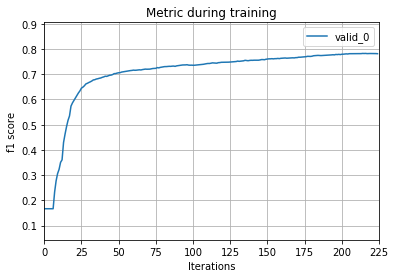

In [8]:
# Plotting the metric results
lgb.plot_metric(evals_result, metric='f1 score')
plt.show()

In [6]:
# Predicting on test dataset
predictions = gbm.predict(test_ds)
print(classification_report(y_test, [np.argmax(i) for i in predictions], target_names=CLASSES))

                   precision    recall  f1-score   support

        економіка       0.74      0.66      0.70       247
         кримінал       0.84      0.87      0.86       670
міжнародні новини       0.81      0.87      0.84       424
         політика       0.82      0.85      0.83       996
            спорт       0.99      0.97      0.98       201
      суспільство       0.73      0.64      0.68       462

         accuracy                           0.82      3000
        macro avg       0.82      0.81      0.82      3000
     weighted avg       0.82      0.82      0.82      3000



In [7]:
def get_prediction_stats(target_test, target_pred=None):
    """
    Prints a map <column_name> -> number of samples.
    If target_pred is provided also gives (<right_predictions>/total) stats.
    """
    
    if target_pred is None:
        print(pd.Series(le.inverse_transform(target_test)).value_counts().sort_index())
    else:
        unique_columns = target_test.unique()
        for column in unique_columns:
            c_pred          = len([y for y, yy in zip(target_test, target_pred) if y == column == yy])
            value_counts    = target_test.value_counts()[column]
            percentage      = (c_pred/value_counts)*100
            print(f'{le.inverse_transform([column])[0]:17s}: {value_counts:5d}, correctly predicted {c_pred:4d} ({percentage:.3f}%)')

In [8]:
get_prediction_stats(headings)

економіка             2610
кримінал              6596
міжнародні новини     4406
політика             10377
спорт                 2256
суспільство           4755
dtype: int64


In [9]:
get_prediction_stats(pd.Series(y_test), target_pred=[np.argmax(i) for i in predictions])

міжнародні новини:   424, correctly predicted  369 (87.028%)
суспільство      :   462, correctly predicted  294 (63.636%)
спорт            :   201, correctly predicted  195 (97.015%)
економіка        :   247, correctly predicted  163 (65.992%)
політика         :   996, correctly predicted  847 (85.040%)
кримінал         :   670, correctly predicted  585 (87.313%)


In [34]:
# Oops
explain_prediction(gbm, train_ds.iloc[1])

Explanation(estimator='<lightgbm.basic.Booster object at 0x0000028F50D010C8>', description=None, error='estimator <lightgbm.basic.Booster object at 0x0000028F50D010C8> is not supported', method=None, is_regression=False, targets=None, feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [10]:
# Saving the model
#model_json = gbm.dump_model()
#
#with open(os.path.join(PROJ_PATH, 'src', 'class_model_lgbm.json'), 'w', encoding='utf-8') as f:
#    json.dump(model_json, f, indent=4)